# Parameter Inference and Calibration: Linking UER to GDP

View target demand as input to the model (instead of a stylized sinusoidal business cycle). 

I see two possible options:
1. GDP growth in line with Okun's Law specifically for unemployment - a 1% change in GDP: 0.03-0.05% change in UER
2. Growth in target demand


/Users/ebbamark/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/collate_macro_vars.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['OBS_VALUE'] = hp_filter.hpfilter(subset['OBS_VALUE'], lamb=1600)[0]*.01+1


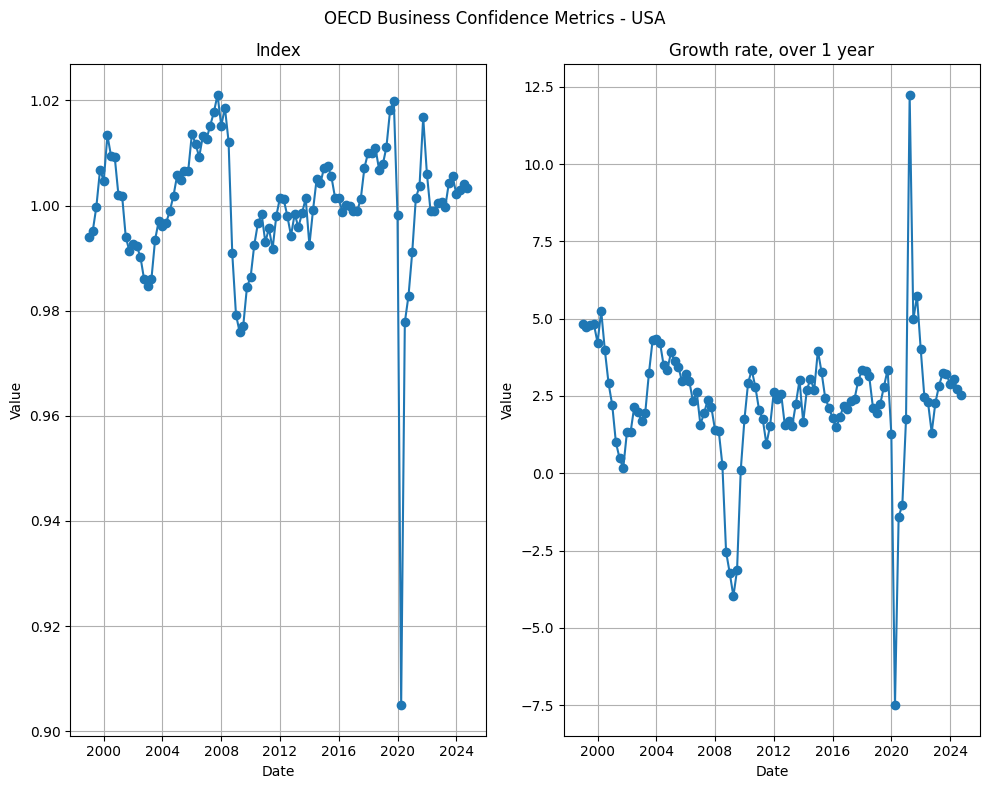

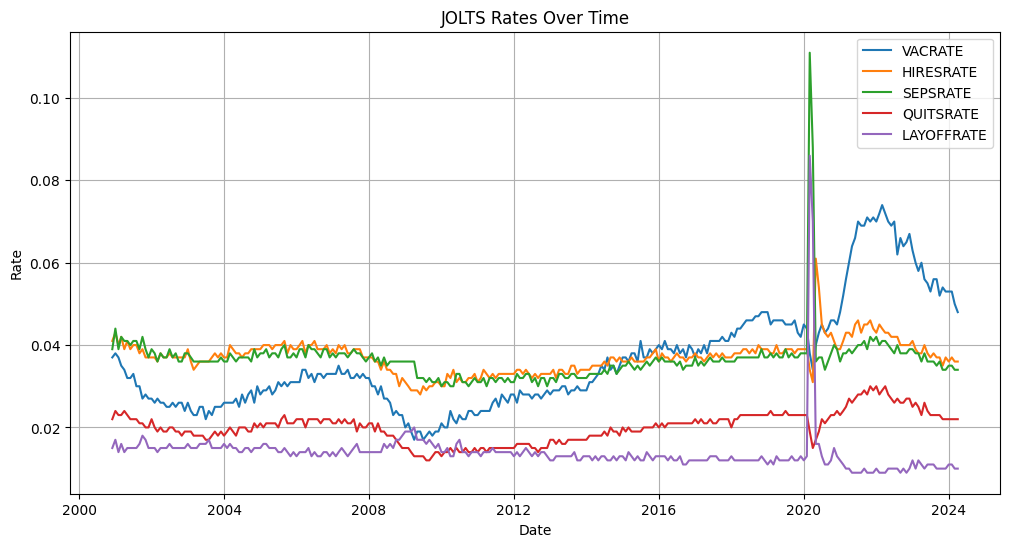

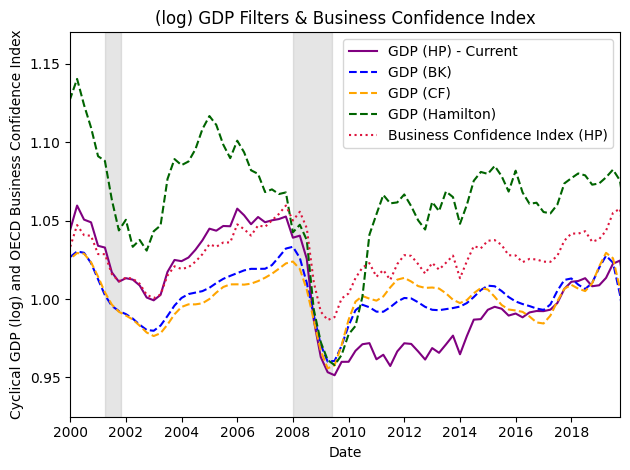

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

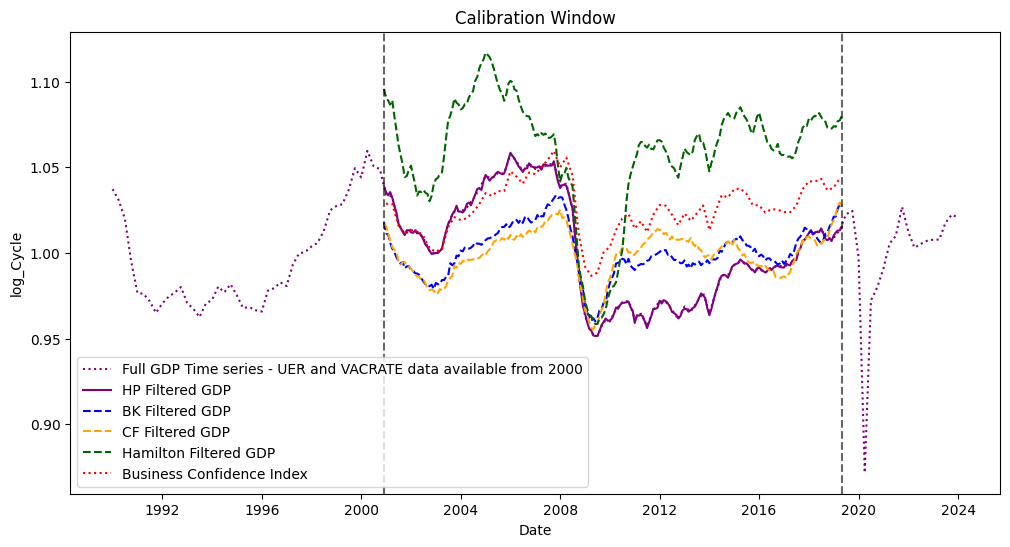

NEW Function import successful
8


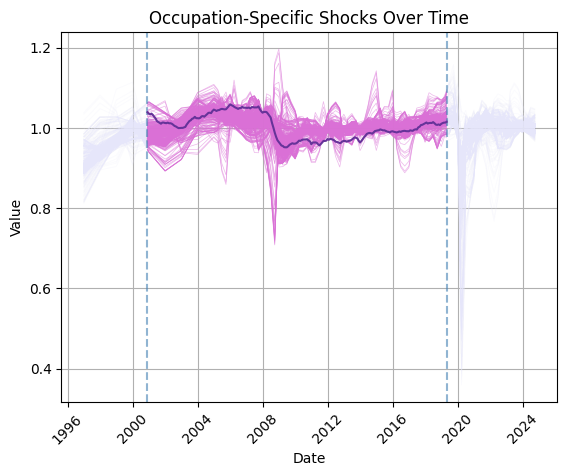

In [1]:
# Import packages
import pandas as pd
from abm_funs import *
from plot_funs import *
from model_fun import *
from collate_macro_vars import *
import numpy as np
import random as random
import matplotlib.pyplot as plt
import tempfile
import pyabc
from scipy.stats import pearsonr, linregress
from pyabc.visualization import plot_kde_matrix, plot_kde_1d
import math as math
from pyabc.transition import MultivariateNormalTransition
import seaborn as sns
from PIL import Image
from pstats import SortKey
import datetime
from collate_macro_vars import *
import csv
from functools import partial

rng = np.random.default_rng()
test_fun()

path: "~/calibration_remote/"

import os
print(os.cpu_count()) 

calib = False
grid_search = True
save = False

222


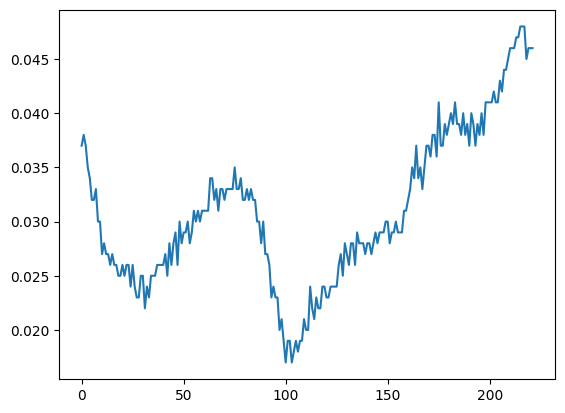

In [2]:

# Macro observations
observation = macro_observations.loc[
    (macro_observations['DATE'] >= calib_date[0]) & 
    (macro_observations['DATE'] <= calib_date[1])
].dropna(subset=["UNRATE", "VACRATE"]).reset_index()

# Load US_input data
A = pd.read_csv(path + "dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path + "dRC_Replication/data/ipums_employment_2016.csv", header=0).iloc[:, [4]] / 10000)

# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment * (0.05 / 0.95))

# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path + "dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean() / 100
vacancies = round(employment * vac_rate_base / (1 - vac_rate_base))

# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path + "dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
occ_ids = pd.read_csv(path + "dRC_Replication/data/ipums_variables.csv")[['id', 'acs_occ_code']]
gend_share = pd.read_csv(path + "data/ipums_variables_w_gender.csv")[['women_pct']]
experience_req = pd.read_csv(path + "dRC_Replication/data/ipums_variables_w_exp.csv")
seps_rates = pd.read_csv(path + "dRC_Replication/data/ipums_variables_w_seps_rate.csv")


mod_data = {
    "A": A,
    "employment": employment,
    'unemployment': unemployment,
    'vacancies': vacancies,
    'demand_target': demand_target,
    'wages': wages,
    'gend_share': gend_share,
    'entry_level': experience_req['entry_level'],
    # 'entry_age': experience_req['entry_age'],
    'experience_age': experience_req['experience_age'],
    'separation_rates': seps_rates['seps_rate']*10
}

# Create complete network
n = A.shape
complete_network = np.ones(n)
mod_data_complete = {
    "A": complete_network,
    "employment": employment,
    'unemployment': unemployment,
    'vacancies': vacancies,
    'demand_target': demand_target,
    'wages': wages,
    'gend_share': gend_share,
    'entry_level': experience_req['entry_level'],
    # 'entry_age': experience_req['entry_age'],
    'experience_age': experience_req['experience_age'],
    'separation_rates': seps_rates['seps_rate']*10

}

###################################
# Initialise the model
##################################
net_temp, vacs = initialise(
    len(mod_data['A']),
    mod_data['employment'].to_numpy(),
    mod_data['unemployment'].to_numpy(),
    mod_data['vacancies'].to_numpy(),
    mod_data['demand_target'].to_numpy(),
    mod_data['A'],
    mod_data['wages'].to_numpy(),
    mod_data['gend_share'].to_numpy(),
    7, 3,
    mod_data['entry_level'],
    mod_data['experience_age'],
    mod_data['separation_rates']
)
net_temp_complete, vacs_complete = initialise(
    len(mod_data_complete['A']),
    mod_data_complete['employment'].to_numpy(),
    mod_data_complete['unemployment'].to_numpy(),
    mod_data_complete['vacancies'].to_numpy(),
    mod_data_complete['demand_target'].to_numpy(),
    mod_data_complete['A'],
    mod_data_complete['wages'].to_numpy(),
    mod_data_complete['gend_share'].to_numpy(),
    7, 3,
    mod_data_complete['entry_level'],
    mod_data_complete['experience_age'],
    mod_data_complete['separation_rates']
)

# Load calibrated parameters from CSV
param_df = pd.read_csv(path + "output/calibrated_params_all.csv")
# Sort by Timestamp in descending order
param_df = param_df.sort_values(by='Timestamp', ascending=False)

params = {
    'mod_data': mod_data,
    'net_temp': net_temp,
    'vacs': vacs,
    'time_steps': len(gdp_dat),
    'delay': 0,
    'gdp_data': gdp_dat,
    'app_effort_dat': duration_to_prob_dict,
    'occ_shocks_data': occ_shocks_dat,
    'steady_state': False
}

# Shorten vac_df to the same length as gdp_dat using a moving average (if needed)
vac_df = observation['VACRATE'].to_numpy()
if len(vac_df) > len(gdp_dat):
    print("smoothing vac_df")
    # Apply moving average with window to smooth and match length
    window = len(vac_df) // len(gdp_dat)
    vac_dat = pd.Series(vac_df).rolling(window=window, min_periods=1).mean()[window-1::window].reset_index(drop=True)
    vac_dat = vac_dat[:len(gdp_dat)]
else:
    vac_dat = vac_df[:len(gdp_dat)]

print(len(vac_dat))
plt.plot(vac_dat, label="Vacancy Rate (smoothed)")

In [3]:

# run_single_local(
#     d_u = 0.01, 
#     #d_v = 0.1,
#     gamma_u = 0.01,
#     #gamma_v = 0.1,
#     otj = True,
#     cyc_otj = True, 
#     cyc_ue = True, 
#     disc = False,
#     mod_data = mod_data, 
#     net_temp = net_temp, 
#     vacs = vacs, 
#     time_steps = len(gdp_dat), # set equal to length of gdp_data
#     delay = 100,
#     gdp_data = gdp_dat,
#     bus_confidence_dat = gdp_dat,
#     app_effort_dat = duration_to_prob_dict,
#     simple_res = True, 
#     vac_data = vac_dat,
#     occ_shocks_data = occ_shocks_dat
# )

In [4]:
def harmonise_length(x, y):
    """
    GDP data used to calibrate has lower periodicity than the UER and VACRATE used for calibration. The following linearly interpolates the simulated output to match the frequency of the UER and Vacancy Rate data
    Harmonises the length of the time series to compare to each other. 
        
    Args:
        x (dict): Simulated data with keys "UER" and "VACRATE".
        y (dict): Real-world data with keys "UER" and "VACRATE".
    
    Returns:
        expanded_format: x expanded via linear interpolation - now of same length as y (observed time series of UER and vacancy rate)
    """
    expanded_format = pd.DataFrame({
        col: np.interp(
            np.linspace(0, len(x[col]) - 1, len(y[col])),
            np.linspace(0, len(x[col]) - 1, len(x[col])),
            x[col]
            )
            for col in x.keys()
            })
    return expanded_format

def distance_weighted(x, y): #weight_shape=0, weight_mean=1):
    x_ = harmonise_length(x, y)
    
    # Normalized SSE using variance
    uer_sse = np.sum((x_["UER"] - y["UER"])**2) / np.var(y["UER"])
    #vacrate_sse = np.sum((x_["VACRATE"] - y["VACRATE"])**2) / np.var(y["VACRATE"])

    # Weighted combination
    dist = (np.sqrt(uer_sse))
    return dist

jolts_obs = jolts[(jolts['DATE'] >= calib_date[0]) & (jolts['DATE'] <= calib_date[1])].reset_index()

def distance_uer_sep_rate(x, y): #weight_shape=0, weight_mean=1):
    x_ = harmonise_length(x, y)
    
    # Normalized SSE using variance
    uer_sse = np.sum((x_["UER"] - y["UER"])**2) / np.var(y["UER"])
    seprate_sse = np.sum((x_["SEPSRATE"] - y["SEPSRATE"])**2) / np.var(y["SEPSRATE"])

    # Weighted combination
    dist = (np.sqrt(uer_sse) + np.sqrt(seprate_sse))
    return dist


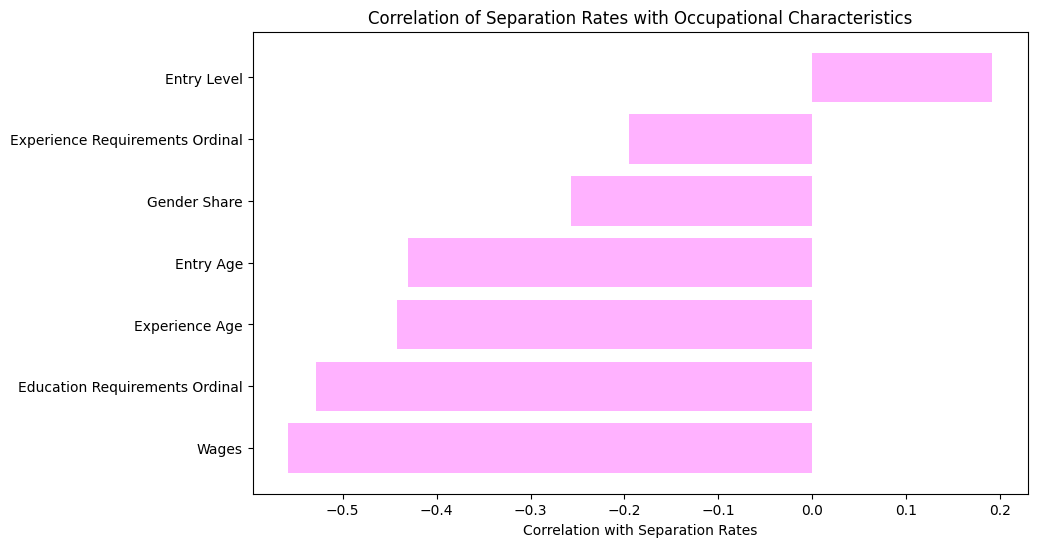

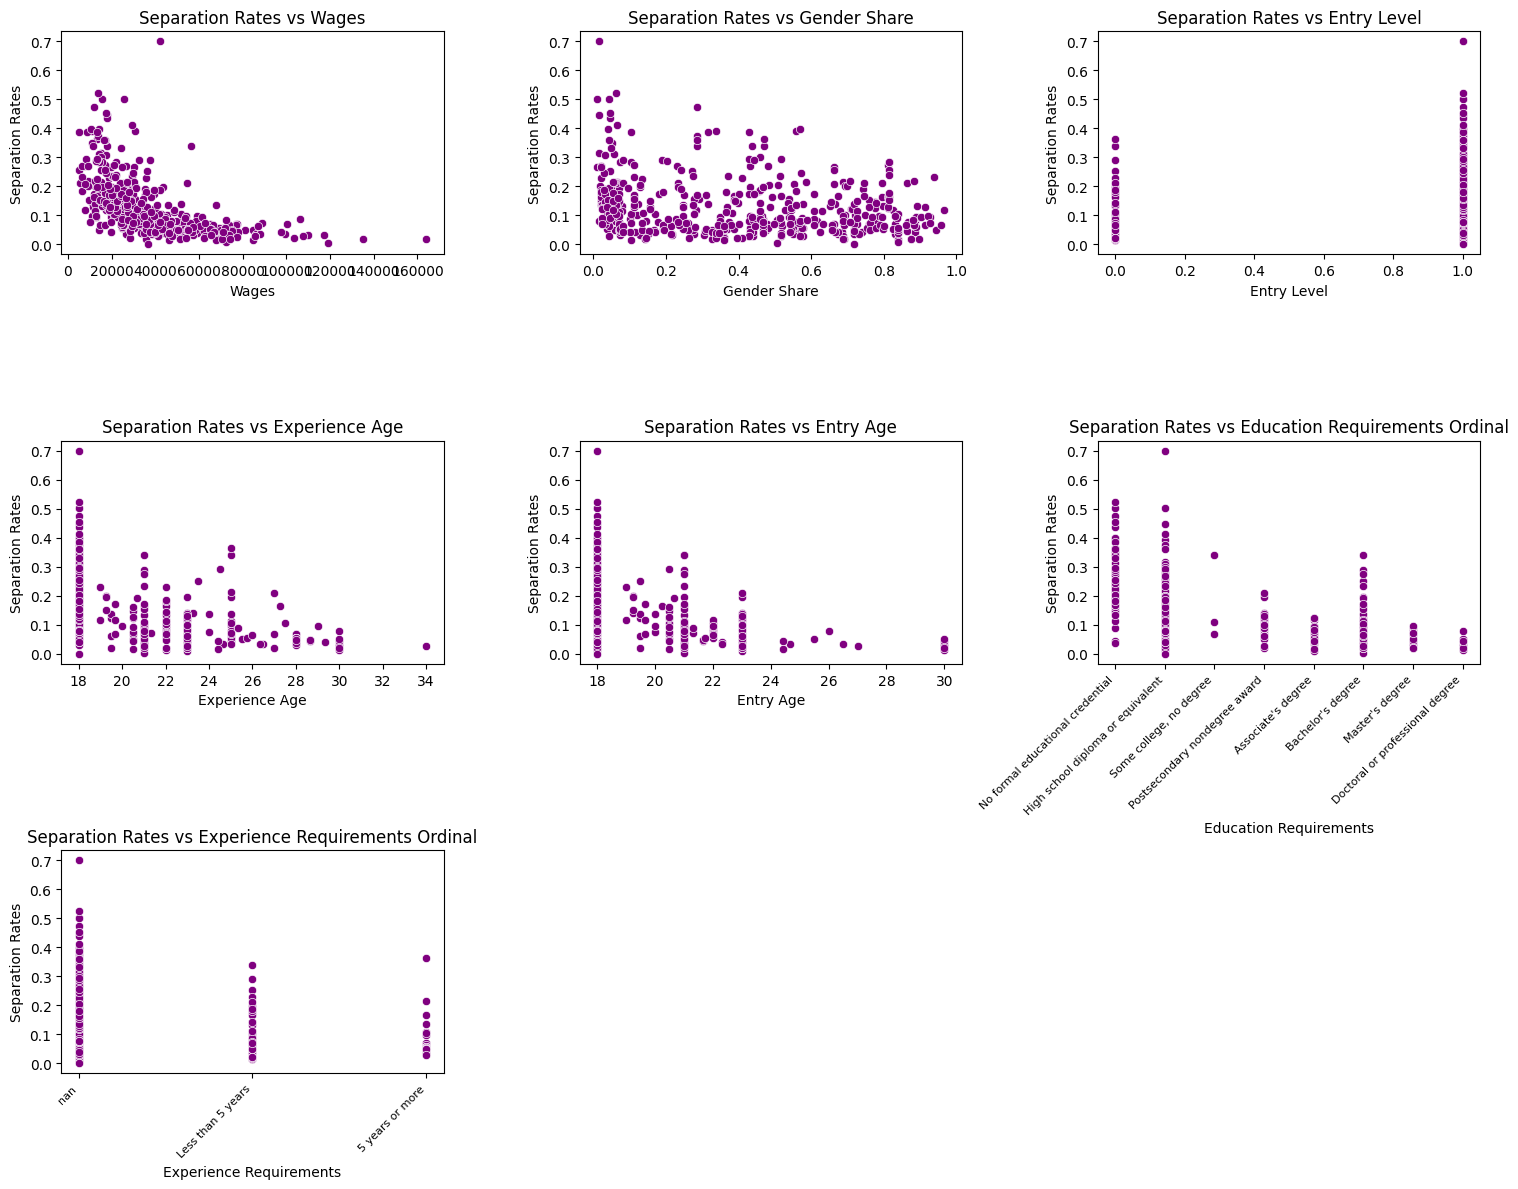

In [5]:
# Prepare DataFrame for correlation analysis
mod_data_df = pd.DataFrame({
    #'Employment': mod_data['employment'],
    'Wages': mod_data['wages']['median_earnings'],
    'Gender Share': mod_data['gend_share']['women_pct'],
    'Entry Level': mod_data['entry_level'],
    'Experience Age': mod_data['experience_age'],
    'Separation Rates': mod_data['separation_rates'],
    'Education Requirements': experience_req['ed_req'],
    'Experience Requirements': experience_req['experience_req'],
    'Entry Age': experience_req['entry_age'],
    'Experience Age': experience_req['experience_age']
})

# Map education requirements to ordinal values
edu_order = [
    'No formal educational credential',
    'High school diploma or equivalent',
    'Some college, no degree',
    'Postsecondary nondegree award',
    "Associate's degree",
    "Bachelor's degree",
    "Master's degree",
    'Doctoral or professional degree'
]

experience_order = [
    np.nan,
    "Less than 5 years",
    "5 years or more"
]
edu_map = {name: i for i, name in enumerate(edu_order)}
mod_data_df['Education Requirements Ordinal'] = mod_data_df['Education Requirements'].map(edu_map)

experience_map = {name: i for i, name in enumerate(experience_order)}
mod_data_df['Experience Requirements Ordinal'] = mod_data_df['Experience Requirements'].map(experience_map)
# Calculate correlations between Separation Rates and other variables
corrs = mod_data_df.drop(columns=['Education Requirements', 'Experience Requirements']).corr()
sep_corrs = corrs['Separation Rates'].drop('Separation Rates')

# Sort correlations by absolute value (or just value)
sep_corrs_sorted = sep_corrs.sort_values()

# Plot correlation coefficients as a bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(sep_corrs_sorted.index, sep_corrs_sorted.values, color='magenta', alpha=0.3)
plt.xlabel('Correlation with Separation Rates')
plt.title('Correlation of Separation Rates with Occupational Characteristics')


# Scatterplots of separation_rates vs each other variable in a 3x3 grid
# Exclude specific columns from scatterplots
exclude_cols = ['Education Requirements', 'Experience Requirements', 'Separation Rates']
other_cols = [col for col in mod_data_df.columns if col not in exclude_cols]
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(other_cols):
    ax = axes[i]
    sns.scatterplot(x=mod_data_df[col], y=mod_data_df['Separation Rates'], color="purple", ax=ax)
    ax.set_ylabel('Separation Rates')
    ax.set_title(f'Separation Rates vs {col}')
    # Custom x-tick labels for ordinal columns
    if col == 'Education Requirements Ordinal':
        ax.set_xticks(range(len(edu_order)))
        ax.set_xticklabels(edu_order, rotation=45, ha='right', fontsize=8)
        ax.set_xlabel('Education Requirements')
    elif col == 'Experience Requirements Ordinal':
        ax.set_xticks(range(len(experience_order)))
        ax.set_xticklabels([str(x) if pd.isna(x) else x for x in experience_order], rotation=45, ha='right', fontsize=8)
        ax.set_xlabel('Experience Requirements')
    else:
        ax.set_xlabel(col)

# Hide any unused subplots
for j in range(len(other_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [6]:
params = {'mod_data': mod_data, 
            'net_temp': net_temp,
            'vacs': vacs, 
            'time_steps': len(gdp_dat),
            'gdp_data': gdp_dat,
            "bus_confidence_dat": gdp_dat,
            'app_effort_dat': duration_to_prob_dict,
            "vac_data": vac_dat,
            'occ_shocks_data': occ_shocks_dat,
            'simple_res': True,
            'delay': 5,
            'steady_state': True}

calib_list = {
    "nonbehav": {"otj": False, # has been run
                           "cyc_otj": False, 
                           "cyc_ue": False, 
                           "disc": False},
              "otj_nonbehav": {"otj": True, # has been run
                           "cyc_otj": False, 
                           "cyc_ue": False, 
                           "disc": False},
    #           "otj_cyclical_e": {"otj": True,
    #                        "cyc_otj": True, 
    #                        "cyc_ue": False, 
    #                        "disc": False,
    #                        "bus_confidence_dat": bus_conf_dat},
            #   "otj_cyclical_ue ": {"otj": True,
            #                "cyc_otj": False, 
            #                "cyc_ue": True, 
            #                "disc": False},
            #   "otj_cyclical_e_ue": {"otj": True,
            #                "cyc_otj": True, 
            #                "cyc_ue": True, 
            #                "disc": False},
              "otj_cyclical_e_disc": {"otj": True,
                           "cyc_otj": True, 
                           "cyc_ue": False, 
                           "disc": True},
              # "otj_cyclical_ue_disc": {"otj": True,
              #              "cyc_otj": False, 
              #              "cyc_ue": True, 
              #              "disc": True},
              # "otj_cyclical_e_ue_disc": {"otj": True,
              #              "cyc_otj": True, 
              #              "cyc_ue": True, 
              #              "disc": True}
              "otj_disc": {"otj": True,
                            "cyc_otj": False, 
                            "cyc_ue": False, 
                            "disc": True}
            }


In [7]:
observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()

if calib:
    prior = pyabc.Distribution(d_u = pyabc.RV("uniform", 0.00001, 0.9),
                        #d_v = pyabc.RV("uniform", 0.00001, 0.06),
                        gamma_u = pyabc.RV("uniform", 0.00001, 0.9))
                        #gamma_v = pyabc.RV("uniform", 0.00001, 1)) 
    
    
    # Define possible distance functions and behav_spec values
    #behav_spec_values = [False, True]

    # CSV filename
    csv_filename = os.path.expanduser(path + f"output/calibrated_params_all.csv")

    # Ensure CSV file starts with headers
    if not os.path.exists(csv_filename):
        with open(csv_filename, "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Parameter", "Value", "otj", "cyc_otj", "cyc_ue", "disc", "Timestamp","model_cat"])


    for name, temp_params in calib_list.items():
        print(f"Running calibration for {name}")

        # Create a new version with different default values
        temp_run = partial(run_single_local, **{**params, **temp_params})
            
        #########################################
        # Wrapper for pyabc ########
        #########################################
        def pyabc_run_single(parameter):     
            res = temp_run(**parameter)
            return res

        # Set up ABC calibration
        calib_sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=2)
        
        abc = pyabc.ABCSMC(pyabc_run_single, prior, distance_weighted, population_size=3, sampler=calib_sampler)

        db_path = os.path.join(tempfile.gettempdir(), f"test_{name}.db")
        # The following creates the "reference" values from the observed data - I pull the non-recession or expansion period from 2010-2019.
        #observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()

        data = {'UER': np.array(observation['UER']),
            'VACRATE': np.array(observation['VACRATE'])}
    
        abc.new("sqlite:///" + db_path, data)

        history = abc.run(minimum_epsilon=0.1, max_nr_populations=2)

        # Extract parameter estimates
        df, w = history.get_distribution(t=history.max_t)
        final_params = {
            "d_u": np.sum(df["d_u"] * w),
            #"d_v": np.sum(df["d_v"] * w),
            "gamma_u": np.sum(df["gamma_u"] * w),
            #"gamma_v": np.sum(df["gamma_v"] * w),
        }

        # Save parameter estimates to CSV
        with open(csv_filename, "a", newline="") as file:
            writer = csv.writer(file)
            for param, value in final_params.items():
                writer.writerow([param, value, temp_params['otj'], temp_params['cyc_otj'], temp_params['cyc_ue'], temp_params['disc'], datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),name])

        # Generate and save plots
        plot_directory = os.path.expanduser(path + "output/")
        os.makedirs(plot_directory, exist_ok=True)
        plot_filename_base = plot_directory + f"calibration_{name}"
        
        # KDE Matrix
        plt.figure()
        plot_kde_matrix(
            df, 
            w, 
            limits={"d_u": (0.00001, 0.9),
                     #"d_v": (0.00001, 0.1),
                       "gamma_u": (0.00001, 0.9)},
                        # "gamma_v": (0.00001, 1)}, 
            refval=final_params, 
            names={"d_u": r"$\delta_u$", 
                   #"d_v": r"$\delta_v$", 
                   "gamma_u": r"$\gamma_u$"} 
                   #"gamma_v": r"$\gamma_v$"}
        )
        plt.savefig(f"{plot_filename_base}_kde_matrix.png", bbox_inches='tight', pad_inches=0.5)
        plt.close()

        # Joint KDE Plot for d_u and gamma_u
        sns.jointplot(x="d_u", y="gamma_u", kind="kde", data=df, weights=w, cmap="viridis_r", marginal_kws={'fill': True})
        plt.xlabel(r'$\delta_u$')
        plt.ylabel(r'$\gamma_u$')
        plt.axvline(x=np.sum(df["d_u"] * w), color="green", linestyle='dashed')
        plt.axhline(y=np.sum(df["gamma_u"] * w), color="green", linestyle='dashed')
        plt.suptitle(r"Kernel Density Estimate: $\delta_u$, $\gamma_u$", y=1.02)
        plt.savefig(f"{plot_filename_base}_joint_delta.png", bbox_inches='tight', pad_inches=0.5)
        plt.close()

        # Simulation Results Plot
        fig, axes = plt.subplots(2, 1, sharex=True)
        fig.set_size_inches(8, 12)
        n = 15  # Number of samples to plot from each category
        alpha = 0.5

        sum_stats = history.get_weighted_sum_stats_for_model(m=0, t=history.max_t)
        calib_date = [pd.to_datetime(calib_date[0]), pd.to_datetime(calib_date[1])]
        buffer = pd.DateOffset(years=1)

        for stored in sum_stats[1][:n]:
            stored_ = harmonise_length(stored, observation)
            date_range = pd.date_range(start=calib_date[0], end=calib_date[1], periods=len(stored_))
            axes[0].plot(date_range, stored_["UER"], color="green", alpha=alpha)
            axes[1].plot(date_range, stored_["VACRATE"], color="green", alpha=alpha)

        #for ax in axes[0]:
        observation.plot(x = "DATE", y="UER", ax=axes[0], color="black", linewidth=1.5)
        axes[0].legend().set_visible(False)
        axes[0].set_ylabel("UER")
        axes[0].set_xlim([calib_date[0], calib_date[1]])

        #for ax in axes[1]:
        observation.plot(x = "DATE", y = "VACRATE", ax=axes[1], color="black", linewidth=1.5)
        axes[1].legend().set_visible(False)
        axes[1].set_ylabel("VACANCY RATE")
        axes[1].set_xlim([calib_date[0] - buffer, calib_date[1] + buffer])
        #ax.yaxis.set_label_position("right")

        fig.suptitle(f"Simulation Results using Parameters from Posterior (sampled & accepted)_{name}")

        fig.legend(
            [
                plt.plot([0], color="green")[0],
                plt.plot([0], color="black")[0],
            ],
            ["Stored, accepted", "Observation"],
            bbox_to_anchor=(0.5, 0.9),
            loc="lower center",
            ncol=4,
        )
        plt.savefig(f"{plot_filename_base}_sim_results.png", bbox_inches='tight', pad_inches=0.5)
        plt.close()

    print("Calibration complete. Results saved to CSV and plots saved as images.")

[]

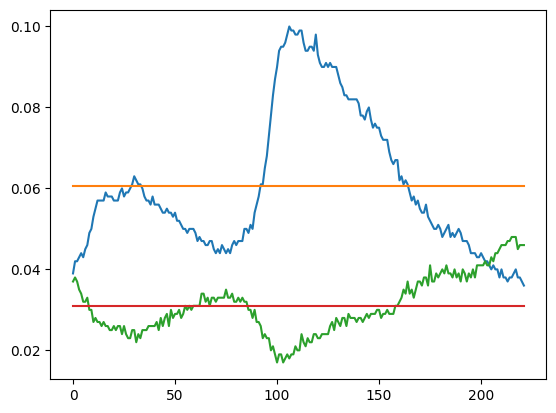

In [8]:
observation_data = {
    "UER": observation["UER"].values,
    "VACRATE": observation["VACRATE"].values,
    "SEPSRATE": jolts_obs["SEPSRATE"].values
}

observation_data_steady_state= {
    "UER": np.full_like(observation["UER"].values, np.nanmean(observation["UER"].values)),
    "VACRATE": np.full_like(observation["VACRATE"].values, np.nanmean(observation["VACRATE"].values)),
    "SEPSRATE": np.full_like(jolts_obs["SEPSRATE"].values, np.nanmean(jolts_obs["SEPSRATE"].values))
}

plt.plot(observation_data['UER'])
plt.plot(observation_data_steady_state['UER'])
plt.plot(observation_data['VACRATE'])
plt.plot(observation_data_steady_state['VACRATE'])
plt.plot()


In [ ]:
if grid_search:
    from itertools import product
    model_cats = ["otj_cyclical_e_disc",  "otj_disc", "nonbehav", "otj_nonbehav"] #  #"nonbehav"]#, "otj_nonbehav"] #, #]

    # Define parameter grid
    nb_d_u_vals = np.linspace(0.001, 0.2, 10)
    nb_gamma_u_vals = np.linspace(0.001, 0.2, 10)

    b_d_u_vals = np.linspace(0.001, 0.2, 10)
    b_gamma_u_vals = np.linspace(0.001, 0.2, 10)

    for model_cat in model_cats:
        if "nonbehav" in model_cat:
            d_u_vals = nb_d_u_vals
            gamma_u_vals = nb_gamma_u_vals
        else:
            d_u_vals = b_d_u_vals
            gamma_u_vals = b_gamma_u_vals

        print(f"\n Starting grid search for model category: {model_cat} with {len(d_u_vals) * len(gamma_u_vals)} parameter combinations")

        setting = calib_list[model_cat]
        grid_params = {**params, **setting}

        # Output CSV per model_cat
        results_csv = os.path.expanduser(path + f"output/steady_state/grid_search_results_{model_cat}.csv")
        if not os.path.exists(results_csv):
            with open(results_csv, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["d_u", "gamma_u", "distance", "otj", "cyc_otj", "cyc_ue", "disc", "timestamp", "model_cat"])

        observation_data = {
            "UER": observation["UER"].values,
            "VACRATE": observation["VACRATE"].values,
            'SEPSRATE': jolts_obs["SEPSRATE"].values
        }

        observation_data_steady_state= {
            "UER": np.full_like(observation["UER"].values, np.nanmean(observation["UER"].values)),
            "VACRATE": np.full_like(observation["VACRATE"].values, np.nanmean(observation["VACRATE"].values)),
            "SEPSRATE": np.full_like(jolts_obs["SEPSRATE"].values, np.nanmean(jolts_obs["SEPSRATE"].values))
        }

        grid_results = []

        for d_u, gamma_u in product(d_u_vals, gamma_u_vals):
            full_params = grid_params.copy()
            full_params.update({"d_u": d_u, "gamma_u": gamma_u})

            try:
                model_output = run_single_local(**full_params)
                if isinstance(model_output, dict):
                    dist = distance_weighted(model_output, observation_data_steady_state)
                else:
                    dist = np.inf

                grid_results.append((d_u, gamma_u, dist))

                with open(results_csv, "a", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerow([
                        d_u, gamma_u, dist,
                        setting['otj'], setting['cyc_otj'], setting['cyc_ue'], setting['disc'],
                        datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                        model_cat
                    ])

                print(f"✓ d_u={d_u:.4f}, gamma_u={gamma_u:.4f}, dist={dist:.4f}")

            except Exception as e:
                print(f"✗ d_u={d_u:.4f}, gamma_u={gamma_u:.4f} → ERROR: {e}")

        # ---------------- Best Parameters ----------------
        grid_results.sort(key=lambda x: x[2])
        best_d_u, best_gamma_u, best_dist = grid_results[0]
        print(f" Best parameters for {model_cat}: d_u={best_d_u:.4f}, gamma_u={best_gamma_u:.4f}, distance={best_dist:.4f}")

        # ---------------- Best-Fit Time Series Plot ----------------
        best_params = grid_params.copy()
        best_params.update({"d_u": best_d_u, "gamma_u": best_gamma_u})
        model_output = run_single_local(**best_params)
        model_output_interp = harmonise_length(model_output, observation_data_steady_state)
        date_range = pd.date_range(start=observation["DATE"].iloc[0], end=observation["DATE"].iloc[-1], periods=len(model_output_interp))

        plt.figure(figsize=(12, 10))
        plt.subplot(3, 1, 1)
        #plt.plot(date_range, observation["UER"], label="Observed UER", color="black", linewidth=2)
        plt.plot(date_range, np.full_like(observation["UER"].values, np.nanmean(observation["UER"].values)), label="Observed UER", color="black", linewidth=2)
        plt.plot(date_range, model_output_interp["UER"], label="Model UER", color="green", linestyle="--")
        plt.title(f"Best-Fit UER — {model_cat}")
        plt.ylabel("UER")
        plt.legend()
        plt.grid(True)

        plt.subplot(3, 1, 2)
        plt.plot(date_range, jolts_obs['SEPSRATE'], label="Observed SEPSRATE", color="black", linewidth=2)
        plt.plot(date_range, model_output_interp["SEPSRATE"], label="Model SEPSRATE", color="blue", linestyle="--")
        plt.title(f"Best-Fit SEPSRATE — {model_cat}")
        plt.ylabel("SEPSRATE")
        plt.xlabel("Date")
        plt.legend()
        plt.grid(True)

        plt.subplot(3, 1, 3)
        #plt.plot(date_range, observation["VACRATE"], label="Observed VACRATE", color="black", linewidth=2)
        plt.plot(observation['DATE'], np.full_like(observation["VACRATE"].values, np.nanmean(observation["VACRATE"].values)), label="Observed VACRATE", color="black", linewidth=2)
        plt.plot(date_range, model_output_interp["VACRATE"], label="Model VACRATE", color="blue", linestyle="--")
        plt.title(f"Best-Fit VACRATE — {model_cat}")
        plt.ylabel("VACRATE")
        plt.xlabel("Date")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(os.path.expanduser(path + f"output/steady_state/best_fit_uer_vacrate_{model_cat}.png"))
        plt.close()

        # ---------------- Heatmap Plot ----------------
        du_vals = sorted(set(x[0] for x in grid_results))
        gu_vals = sorted(set(x[1] for x in grid_results))
        du_idx = {val: i for i, val in enumerate(du_vals)}
        gu_idx = {val: i for i, val in enumerate(gu_vals)}
        heatmap = np.full((len(gu_vals), len(du_vals)), np.nan)

        for d_u, gamma_u, dist in grid_results:
            i = gu_idx[gamma_u]
            j = du_idx[d_u]
            heatmap[i, j] = dist

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            heatmap,
            xticklabels=[f"{v:.3f}" for v in du_vals],
            yticklabels=[f"{v:.3f}" for v in gu_vals],
            cmap="viridis",
            annot=True,
            fmt=".2f"
        )
        plt.title(f"Distance Surface — {model_cat}")
        plt.xlabel("d_u")
        plt.ylabel("gamma_u")
        plt.tight_layout()
        plt.savefig(os.path.expanduser(path + f"output/steady_state/grid_search_heatmap_{model_cat}.png"))
        plt.close()


 Starting grid search for model category: otj_cyclical_e_disc with 100 parameter combinations
✓ d_u=0.0010, gamma_u=0.0010, dist=117325268902459520.0000
✓ d_u=0.0010, gamma_u=0.0231, dist=53253967970763240.0000
✓ d_u=0.0010, gamma_u=0.0452, dist=39766075891499856.0000
✓ d_u=0.0010, gamma_u=0.0673, dist=50466558971736456.0000
✓ d_u=0.0010, gamma_u=0.0894, dist=64398869627663200.0000
✓ d_u=0.0010, gamma_u=0.1116, dist=76325378801697808.0000
✓ d_u=0.0010, gamma_u=0.1337, dist=84993085307155248.0000
✓ d_u=0.0010, gamma_u=0.1558, dist=88025734739800768.0000
✓ d_u=0.0010, gamma_u=0.1779, dist=93055801561152048.0000
✓ d_u=0.0010, gamma_u=0.2000, dist=99030624613874736.0000
✓ d_u=0.0231, gamma_u=0.0010, dist=111125439682221472.0000
✓ d_u=0.0231, gamma_u=0.0231, dist=137418725225384448.0000
✓ d_u=0.0231, gamma_u=0.0452, dist=150591063373276576.0000
✓ d_u=0.0231, gamma_u=0.0673, dist=158577476613620128.0000
✓ d_u=0.0231, gamma_u=0.0894, dist=168449955645464992.0000
✓ d_u=0.0231, gamma_u=0.1116,

In [ ]:
#---------------- Best Parameters ----------------
if grid_search:
    model_cats = ["otj_cyclical_e_disc" , "otj_disc",  "nonbehav", "otj_nonbehav"]
    for model_cat in model_cats:
        import matplotlib.gridspec as gridspec

        grid_results = pd.read_csv(f'{path}output/steady_state/grid_search_results_{model_cat}.csv')
        grid_results = grid_results.sort_values(by='distance', ascending=True).reset_index(drop=True)
        best_d_u, best_gamma_u, best_dist = grid_results['d_u'].iloc[0], grid_results['gamma_u'].iloc[0], grid_results['distance'].iloc[0]
        print(f" Best parameters for {model_cat}: d_u={best_d_u:.4f}, gamma_u={best_gamma_u:.4f}, distance={best_dist:.4f}")

        setting = calib_list[model_cat]
        grid_params = {**params, **setting}
        best_params = grid_params.copy()
        best_params.update({"d_u": best_d_u, "gamma_u": best_gamma_u, 'simple_res': True})
        model_output = run_single_local(**best_params)
        date_range = pd.date_range(start=observation["DATE"].iloc[0], end=observation["DATE"].iloc[-1], periods=len(model_output['UER']))

        # Create a figure with 2 rows using gridspec
        fig = plt.figure(figsize=(8, 12))
        gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1.5])

        # First plot: Best-Fit Time Series
        ax1 = fig.add_subplot(gs[0])
        #ax1.plot(observation['DATE'], observation["UER"], label="Observed UER", color="black", linewidth=2)
        ax1.plot(observation['DATE'], np.full_like(observation["UER"].values, np.nanmean(observation["UER"].values)), label="Observed UER", color="black", linewidth=2)
        ax1.plot(date_range, model_output["UER"], label="Model UER", color="green", linestyle="--")
        ax1.set_title(f"Best-Fit UER — {model_cat}")
        ax1.set_ylabel("UER")
        ax1.legend()
        ax1.grid(True)

        ax2 = fig.add_subplot(gs[1])
        #ax2.plot(observation['DATE'], observation["VACRATE"], label="Observed VACRATE", color="black", linewidth=2, alpha=0.5)
        ax2.plot(observation['DATE'], np.full_like(observation["VACRATE"].values, np.nanmean(observation["VACRATE"].values)), label="Observed VACRATE", color="black", linewidth=2)
        ax2.plot(date_range, model_output["VACRATE"], label="Model VACRATE", color="blue", linestyle="--", alpha=0.5)
        ax2.set_ylabel("VACRATE")
        ax2.legend(loc="lower right")
        ax2.grid(True)

        # Second plot: Heatmap
        ax3 = fig.add_subplot(gs[2])
        heatmap_data = grid_results.pivot_table(index='d_u', columns='gamma_u', values='distance')
        sns.heatmap(
            heatmap_data,
            cmap='viridis',
            annot=False,
            cbar_kws={'label': 'Distance'},
            xticklabels=[f"{x:.3f}" for x in heatmap_data.columns],
            yticklabels=[f"{y:.3f}" for y in heatmap_data.index],
            ax=ax3
        )
        ax3.set_xlabel('gamma_u')
        ax3.set_ylabel('d_u')
        ax3.set_title(f'Grid Search Results Heatmap — {model_cat}')

        plt.tight_layout()
        #plt.show()
        plt.savefig(os.path.expanduser(path + f"output/steady_state/best_fit_and_heatmap_{model_cat}.png"))
        plt.close(fig)


 Best parameters for otj_cyclical_e_disc: d_u=0.0010, gamma_u=0.2000, distance=97271144804193264.0000
